In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

#import Lambda
from tensorflow.keras.layers import Lambda

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  load_img
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Lambda
#import concatenate
from tensorflow.keras.layers import Concatenate

c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [4]:
np.loadtxt('mnist_background_images/mnist_background_images_train.amat').shape

(12000, 785)

In [85]:
# read amat
mnist_back_train_data = np.loadtxt('mnist_background_images/mnist_background_images_train.amat')
mnist_back_test_data = np.loadtxt('mnist_background_images/mnist_background_images_test.amat')

mnist_back_train_label = mnist_back_train_data[:,-1]
mnist_back_test_label = mnist_back_test_data[:,-1]

mnist_back_train_data = mnist_back_train_data[:,:-1]
mnist_back_test_data = mnist_back_test_data[:,:-1]


In [86]:
mnist_back_train_data = mnist_back_train_data.reshape(-1, 28, 28, 1)
mnist_back_test_data = mnist_back_test_data.reshape(-1, 28, 28, 1)


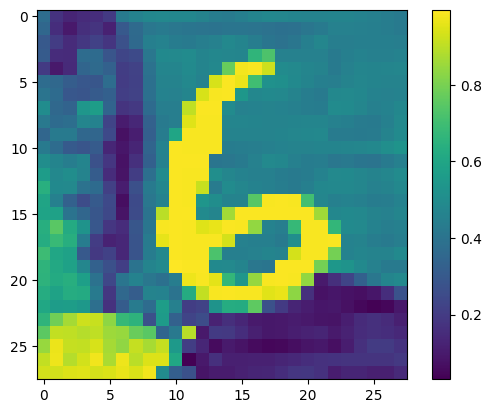

In [91]:

# rotate 90 degrees to the right and revert

mnist_back_train_data_rotated = np.rot90(mnist_back_train_data, axes=(1,2))
# revert
mnist_back_train_data_rotated = mnist_back_train_data_rotated[:,::-1,:]
plt.imshow(mnist_back_train_data_rotated[29])
plt.colorbar()

In [92]:
# load mnist dataset from keras

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

classes = list(range(10))

In [3]:
# # # define triplet generator (entire batch)

# def data_generator(batch_size=64):
#     while True:
#         a = []
#         p = []
#         n = []
#         for _ in range(batch_size):
#             # (28,28, 1) to (28, 28, 3) making 3 copies of the image
#             x_test_rgb = tf.tile(x_train, [1, 1, 1, 3])

#             pos_neg = random.sample(classes, 2)
#             positive_samples = random.sample(list(x_test_rgb[y_train == pos_neg[0]]), 2)
#             negative_sample = random.choice(list(x_test_rgb[y_train == pos_neg[1]]))

#             a.append(positive_samples[0])
#             p.append(positive_samples[1])
#             n.append(negative_sample)
#         yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [4]:
# Define triplet generator (current batch)

def data_generator(batch_size=128):
    while True:
        a = []
        p = []
        n = []
        for _ in range(batch_size):
            # Get a batch of input samples from x_train and y_train
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            batch_images = x_train[batch_indices]
            batch_labels = y_train[batch_indices]

            # Convert images to RGB
            x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

            # Generate triplet samples
            for i in range(batch_size):
                pos_neg = random.sample(classes, 2)
                positive_samples = random.sample(list(x_batch_rgb[batch_labels == pos_neg[0]]), 2)
                negative_sample = random.choice(list(x_batch_rgb[batch_labels == pos_neg[1]]))

                a.append(positive_samples[0])
                p.append(positive_samples[1])
                n.append(negative_sample)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define triplet generator (stratified)
def data_generator(batch_size=100):
    while True:
        a = []
        p = []
        n = []

        # Perform stratified sampling on the training data
        stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
        _, stratified_indices = next(stratified_split.split(x_train, y_train))

        # Get a batch of stratified indices
        batch_indices = np.random.choice(stratified_indices, size=batch_size, replace=False)
        batch_images = x_train[batch_indices]
        batch_labels = y_train[batch_indices]

        # Convert images to RGB
        x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

        # Generate triplet samples
        for i in range(batch_size):
            pos_neg = random.sample(classes, 2)
            positive_samples = random.sample(list(x_batch_rgb[batch_labels == pos_neg[0]]), 2)
            negative_sample = random.choice(list(x_batch_rgb[batch_labels == pos_neg[1]]))

            a.append(positive_samples[0])
            p.append(positive_samples[1])
            n.append(negative_sample)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [26]:
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class
        indices = defaultdict(list)
        for index, label in enumerate(y_train):
            indices[label].append(index)

        # Get a batch of random indices (at least two examples per class)

        # garantir que o target apareça no triplet
        # amostrar de cada fonte e montar 64 triplets


        batch_indices = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[1]], 1)[0])

        # Get a batch of input samples from x_train and y_train
        batch_images = x_train[batch_indices]
        batch_labels = y_train[batch_indices]

        # Convert images to RGB
        # if batch_images.shape[-1] != 3:
        #     x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

        #     # Generate triplet samples
        #     for i in range(batch_size):
        #         a.append(x_batch_rgb[i * 3])
        #         p.append(x_batch_rgb[i * 3 + 1])
        #         n.append(x_batch_rgb[i * 3 + 2])

        # else:
        # Generate triplet samples
        for i in range(batch_size):
            a.append(batch_images[i * 3])
            p.append(batch_images[i * 3 + 1])
            n.append(batch_images[i * 3 + 2])

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [31]:
def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:20]
    positive_out = y_pred[:, 20:40]
    negative_out = y_pred[:, 40:60]

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

    probs = K.softmax([pos_dist, neg_dist], axis=0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))



input_layer = Input((28, 28, 1))
X = Conv2D(32, (3, 3), activation="relu")(input_layer)
X = MaxPool2D()(X)
X = Conv2D(64, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Flatten()(X)
X = Dense(20, activation="relu")(X)

model = Model(input_layer, X)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0   

In [32]:
triplet_model_a = Input((28, 28, 1))
triplet_model_p = Input((28, 28, 1))
triplet_model_n = Input((28, 28, 1))

triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
triplet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 20)           50836       ['input_6[0][0]',                
                                                                  'input_7[0][0]',          

In [33]:
triplet_model.compile(loss = triplet_loss, optimizer='adam')

In [34]:
history = triplet_model.fit(data_generator(), epochs=10, steps_per_epoch=200)

Epoch 1/10
200/200 [==============================] - 23s 28ms/step - loss: 0.1907
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0699
Epoch 3/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0501
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0432
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0399
Epoch 6/10
200/200 [==============================] - 5s 22ms/step - loss: 0.0397
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0330
Epoch 8/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0298
Epoch 9/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0276
Epoch 10/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0241


In [11]:
# x_test = tf.tile(x_test, [1, 1, 1, 3])
# x_train = tf.tile(x_train, [1, 1, 1, 3])

In [35]:

model_embeddings_train = triplet_model.layers[3].predict(x_train)

1875/1875 [==============================] - 6s 2ms/step


In [36]:
model_embeddings_train.shape

(60000, 20)

In [37]:
model_embeddings_test =  triplet_model.layers[3].predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [38]:
model_embeddings_test.shape

(10000, 20)

In [39]:
reduced_embeddings_train = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train)
print(reduced_embeddings_train.shape)

(60000, 2)


In [40]:
reduced_embeddings_test = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_test)
print(reduced_embeddings_test.shape)

(10000, 2)


In [41]:
import matplotlib.pyplot as plt

train

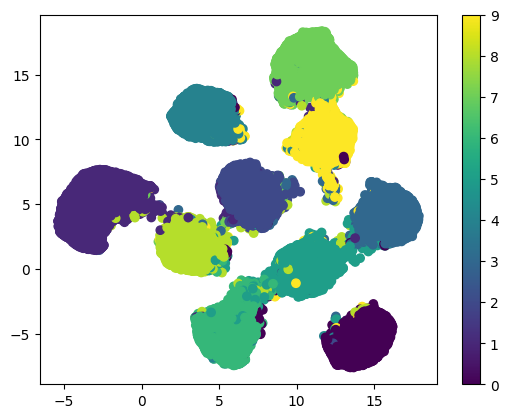

In [42]:
plt.scatter(reduced_embeddings_train[:, 0], reduced_embeddings_train[:,1], c=y_train)
plt.colorbar()

test

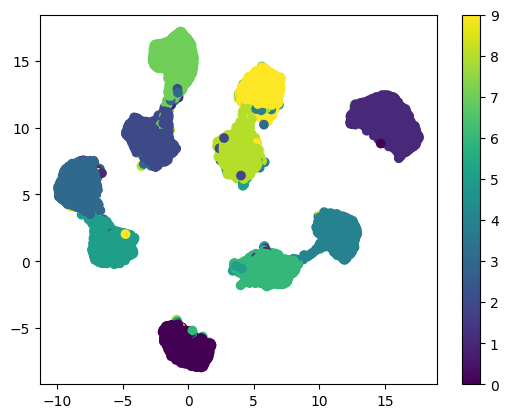

In [43]:
plt.scatter(reduced_embeddings_test[:, 0], reduced_embeddings_test[:,1], c=y_test)
plt.colorbar()

# Classificador
 tentar knn - regularizacao - pca

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


rf = RandomForestClassifier(n_estimators=50)
lr = LogisticRegression()

rf.fit(model_embeddings_train, y_train)
lr.fit(model_embeddings_train, y_train)

print(rf.score(model_embeddings_train, y_train))
print(lr.score(model_embeddings_train, y_train))

c:\Users\levy\miniconda3\envs\keras\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9999833333333333
0.9785333333333334


In [45]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, rf.predict(model_embeddings_test)))
print(accuracy_score(y_test, lr.predict(model_embeddings_test)))

0.9804
0.9795


In [46]:
# from sklearn.metrics import accuracy_score

# print(accuracy_score(y_train_m, rf.predict(model_embeddings_train_m)))
# print(accuracy_score(y_train_m, lr.predict(model_embeddings_train_m)))

NameError: name 'y_train_m' is not defined

juntar as imagens do mnist e mnist m na mesma classe

In [7]:
# juntar as imagens do mnist e mnistm na mesma classe

# Path: mnistm.py
import os
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# each folder contains images of a specific digit
# root folder "/mnistm_labels"
def load_mnistm():
    root = "mnistm_labels"
    folders = os.listdir(root)
    images = []
    labels = []
    for folder in folders:
        for image_path in os.listdir(os.path.join(root, folder)):
            image = Image.open(os.path.join(root, folder, image_path))
            image = np.array(image)
            images.append(image)
            labels.append(int(folder))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# load mnistm dataset


In [8]:

x_train_m, y_train_m = load_mnistm()


In [9]:
x_train_m.shape

(288, 28, 28, 3)

In [10]:
x_train.shape

TensorShape([60000, 28, 28, 3])

In [12]:
x_train_m.shape

(288, 28, 28, 3)

In [48]:
mnist_back_train_data.shape

(50000, 28, 28)

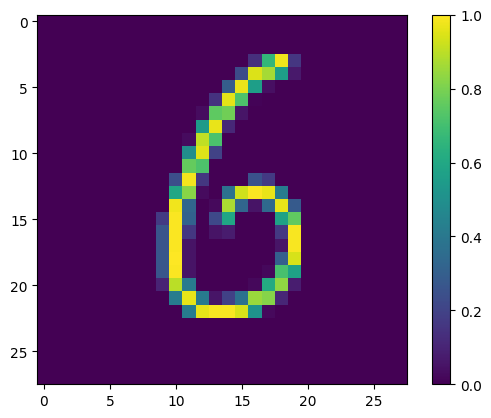

In [93]:
plt.imshow(x_train[18])
plt.colorbar()

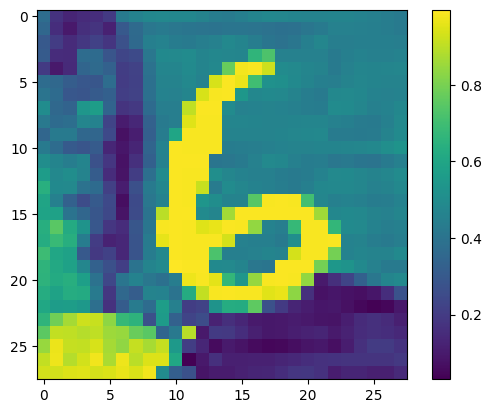

In [94]:
plt.imshow(mnist_back_train_data_rotated[29])
plt.colorbar()

In [60]:
x_train.shape

(60000, 28, 28, 1)

In [96]:
mnist_back_train_data_rotated.shape

(12000, 28, 28, 1)

In [97]:
mnist_back_train_label

array([9., 0., 3., ..., 4., 1., 3.])

In [98]:
all_images = np.concatenate([x_train, mnist_back_train_data_rotated], axis=0)
display(all_images.shape)

all_labels = np.concatenate([y_train, mnist_back_train_label], axis=0)

display(all_labels.shape)

(72000, 28, 28, 1)

(72000,)

In [99]:
all_images.shape

(72000, 28, 28, 1)

# retreinar o modelo usando as novas imagens

garantir que o modelo vai ler o mnist modificado

In [100]:
# x_train = all_images
# y_train = all_labels
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class in the original MNIST dataset
        indices = defaultdict(list)
        for index, label in enumerate(y_train):
            indices[label].append(index)

        # Create a dictionary of indices belonging to each class in the modified MNIST dataset
        indices_modified = defaultdict(list)
        for index, label in enumerate(y_train_m):
            indices_modified[label].append(index)

        # Get a batch of random indices (at least two examples per class)
        batch_indices = []
        batch_indices_p = []
        batch_indices_n = []
        for _ in range(batch_size):
            pos_neg = random.sample(list(indices_modified.keys()), 2)
            anchor_index = random.sample(indices_modified[pos_neg[0]], 1)[0]
            positive_index = random.sample(indices_modified[pos_neg[0]], 1)[0]
            negative_index = random.sample(indices_modified[pos_neg[1]], 1)[0]
            batch_indices.append(anchor_index)
            batch_indices_p.append(positive_index)
            batch_indices_n.append(negative_index)

        # Get a batch of input samples from x_train and x_train_m
        batch_images_anchor = np.array([x_train_m[idx] for idx in batch_indices])
        batch_images_positive = np.array([x_train_m[idx] for idx in batch_indices_p])
        batch_images_negative = np.array([x_train_m[idx] for idx in batch_indices_n])


        for i in range(batch_size):
            # Get anchor image
            anchor_image = batch_images_anchor[i]
            # Get positive image
            pos_image = batch_images_positive[i]
            # Get negative image
            neg_image = batch_images_negative[i]

            # Append samples to their respective lists
            a.append(anchor_image)
            p.append(pos_image)
            n.append(neg_image)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))



triplet_model.fit(data_generator(), epochs=5, steps_per_epoch=150)

NameError: name 'y_train_m' is not defined

In [101]:
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class
        indices = defaultdict(list)
        for index, label in enumerate(all_labels):
            indices[label].append(index)

        # Get a batch of random indices (at least two examples per class)

        # garantir que o target apareça no triplet
        # amostrar de cada fonte e montar 64 triplets


        batch_indices = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[1]], 1)[0])

        # Get a batch of input samples from x_train and y_train
        batch_images = all_images[batch_indices]

 
        for i in range(batch_size):
            a.append(batch_images[i * 3])
            p.append(batch_images[i * 3 + 1])
            n.append(batch_images[i * 3 + 2])

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [108]:
triplet_model.fit(data_generator(), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0541
Epoch 2/10
150/150 [==============================] - 4s 30ms/step - loss: 0.0487
Epoch 3/10
150/150 [==============================] - 4s 30ms/step - loss: 0.0489
Epoch 4/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0433
Epoch 5/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0453
Epoch 6/10
150/150 [==============================] - 5s 30ms/step - loss: 0.0355
Epoch 7/10
150/150 [==============================] - 4s 30ms/step - loss: 0.0357
Epoch 8/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0413
Epoch 9/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0407
Epoch 10/10
150/150 [==============================] - 5s 30ms/step - loss: 0.0339


In [109]:
model_embeddings_train_m = triplet_model.layers[3].predict(mnist_back_train_data_rotated)

375/375 [==============================] - 1s 3ms/step


In [110]:
model_embeddings_train_m.shape

(12000, 20)

In [111]:
reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)
print(reduced_embeddings_train_m.shape)

(12000, 2)


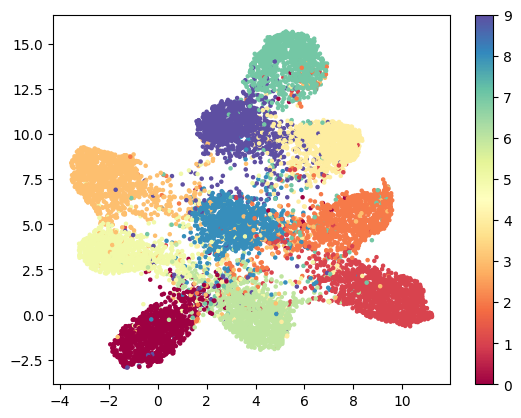

In [112]:
plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.colorbar()

In [ ]:
# get the error from the target domain (x_train_m, y_train_m)


